Loading data for subject s01...
Data shape: (176, 250, 5)

Analyzing Pre-decision epoch (250ms): 176 trials, 5 electrodes
Computing spectral Granger causality...


Target electrodes: 100%|██████████████████████████| 5/5 [00:00<00:00, 10.17it/s]



Results:
  Mean GC: 0.3790
  Max GC: 0.6487
  Non-zero connections: 20/20

Network Summary:
  Electrode  Out-Strength  In-Strength  Hub-Score      Role
0        E0      2.239015     1.509433   0.729581    Driver
3        E3      1.920816     1.848359   0.072457    Driver
2        E2      1.733274     1.991580  -0.258307  Receiver
4        E4      1.792472     2.060090  -0.267617  Receiver
1        E1      1.790655     2.066769  -0.276114  Receiver

Computing time-domain Granger for comparison...


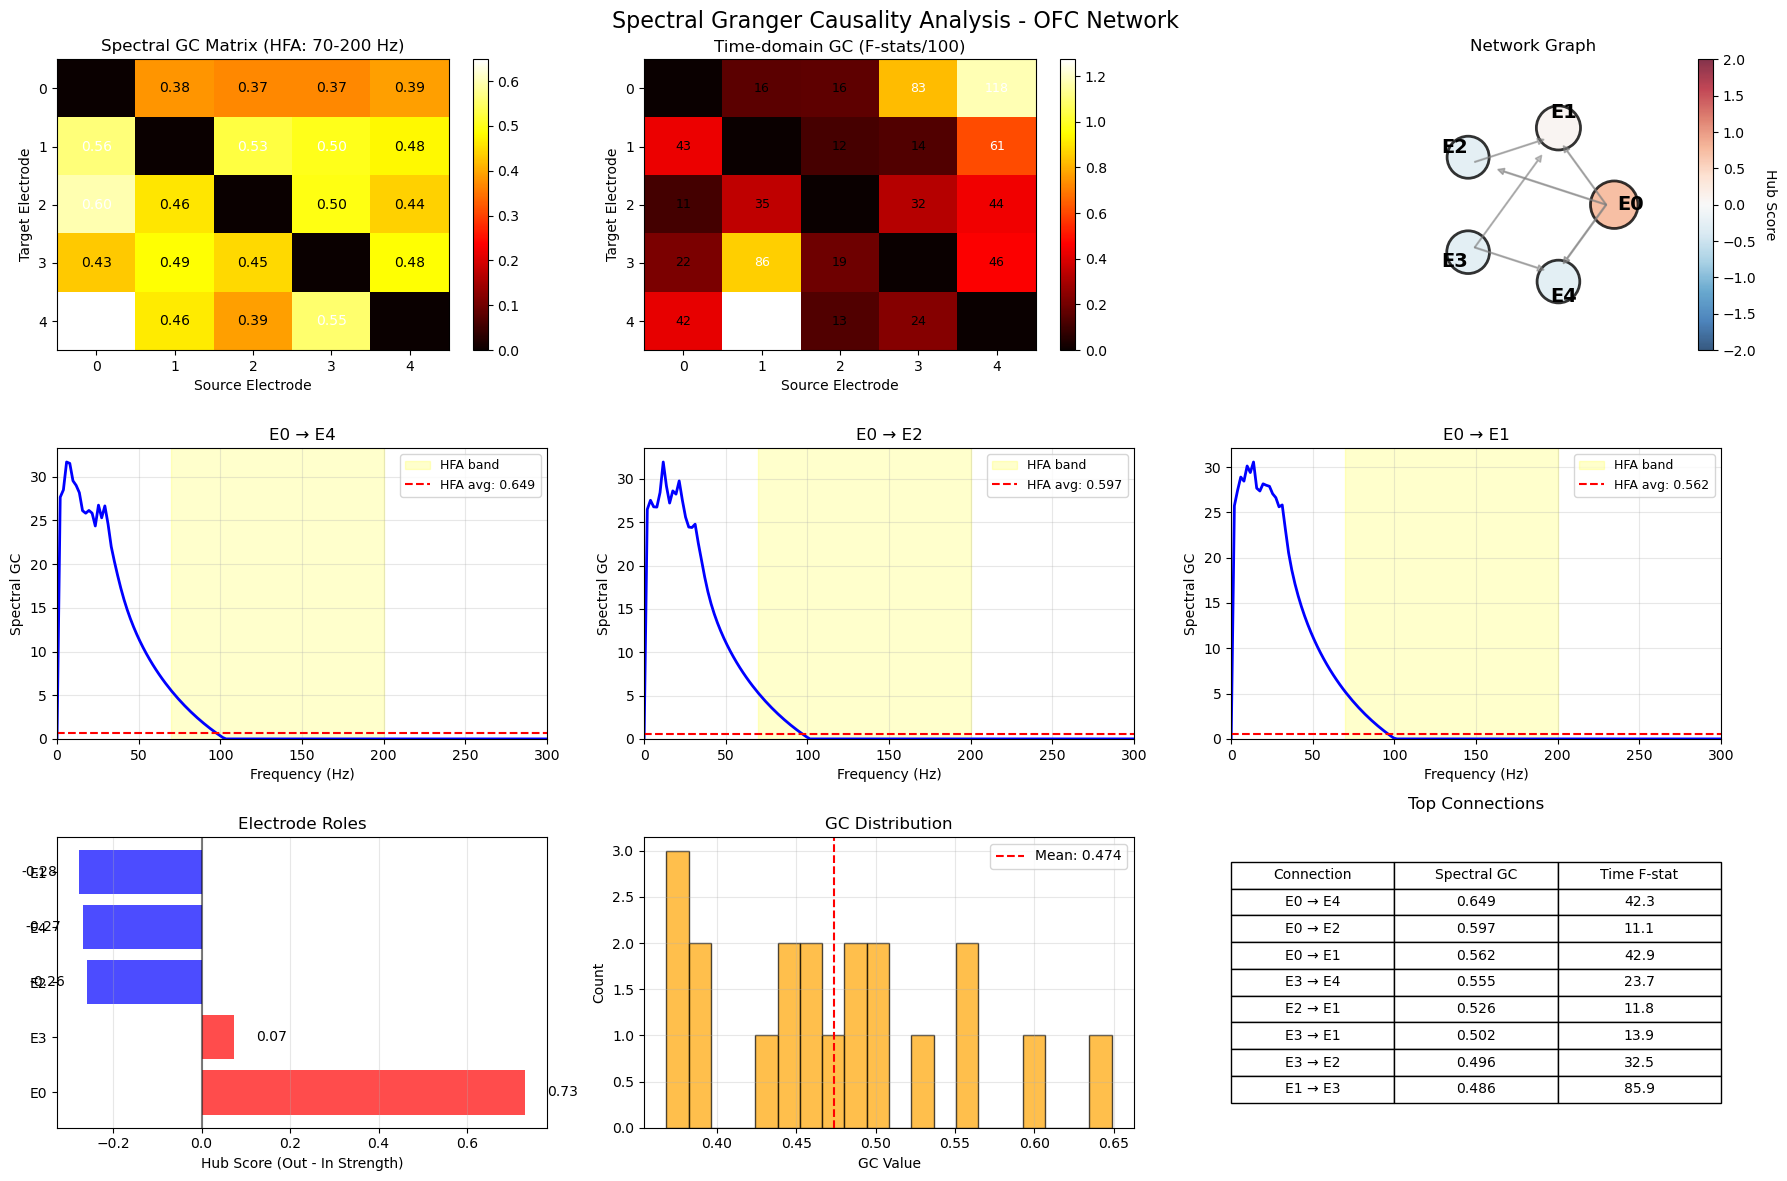


EPOCH COMPARISON

Analyzing pre_decision: 176 trials, 5 electrodes
Computing spectral Granger causality...


Target electrodes: 100%|██████████████████████████| 5/5 [00:00<00:00, 12.62it/s]



Results:
  Mean GC: 0.3790
  Max GC: 0.6487
  Non-zero connections: 20/20

Analyzing value_encoding: 176 trials, 5 electrodes
Computing spectral Granger causality...


Target electrodes: 100%|██████████████████████████| 5/5 [00:00<00:00, 12.28it/s]



Results:
  Mean GC: 0.3616
  Max GC: 0.5886
  Non-zero connections: 20/20

Analyzing decision_formation: 176 trials, 5 electrodes
Computing spectral Granger causality...


Target electrodes: 100%|██████████████████████████| 5/5 [00:00<00:00, 12.09it/s]


Results:
  Mean GC: 0.3718
  Max GC: 0.5543
  Non-zero connections: 20/20

Epoch differences (mean absolute change):
Pre-decision → Value encoding: 0.0486
Value encoding → Decision: 0.0623

Results saved to s01_final_granger_results.npy

KEY FINDINGS FOR DCM MODELING

1. STRONGEST CONNECTIONS (Spectral GC > 0.5):
   E0 → E1: 0.562
   E2 → E1: 0.526
   E3 → E1: 0.502
   E0 → E2: 0.597
   E0 → E4: 0.649
   E3 → E4: 0.555

2. HUB ELECTRODES:
   Primary driver: E0 (score: 0.730)
   Primary receiver: E1 (score: -0.276)

3. RECIPROCAL CONNECTIONS:
   E0 ↔ E1: 0.562 / 0.381
   E0 ↔ E2: 0.597 / 0.368
   E0 ↔ E3: 0.431 / 0.369
   E0 ↔ E4: 0.649 / 0.391
   E1 ↔ E2: 0.460 / 0.526
   E1 ↔ E3: 0.486 / 0.502
   E1 ↔ E4: 0.464 / 0.477
   E2 ↔ E3: 0.447 / 0.496
   E2 ↔ E4: 0.393 / 0.440
   E3 ↔ E4: 0.555 / 0.485


In [6]:
import numpy as np
import scipy.io as sio
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SpectralGrangerFixed:
    
    def __init__(self, sampling_rate=1000, freq_range=(70, 200)):
        self.fs = sampling_rate
        self.freq_range = freq_range
        self.nyquist = sampling_rate / 2
        
    def compute_spectral_gc(self, x, y, model_order=20):
        x = signal.detrend(x.flatten())
        y = signal.detrend(y.flatten())
        x = (x - np.mean(x)) / (np.std(x) + 1e-10)
        y = (y - np.mean(y)) / (np.std(y) + 1e-10)
        
        data = np.column_stack([x, y])
        
        try:
            model = VAR(data)
            results = model.fit(model_order)
            
            coefs = results.coefs
            sigma = results.sigma_u + np.eye(2) * 1e-10
            
            n_freqs = 257
            freqs = np.linspace(0, self.nyquist, n_freqs)
            gc_xy = np.zeros(n_freqs)
            gc_yx = np.zeros(n_freqs)
            
            for i, freq in enumerate(freqs):
                if freq == 0:
                    continue
                    
                omega = 2 * np.pi * freq / self.fs
                
                A_omega = np.eye(2, dtype=complex)
                for k in range(model_order):
                    A_omega -= coefs[k] * np.exp(-1j * omega * (k + 1))
                
                H = np.linalg.inv(A_omega)
                
                S = H @ sigma @ H.conj().T
                
                S_xx = np.abs(S[0, 0])
                S_yy = np.abs(S[1, 1])
                
                if S_yy > sigma[1, 1]:
                    gc_xy[i] = np.log(S_yy / sigma[1, 1])
                
                if S_xx > sigma[0, 0]:
                    gc_yx[i] = np.log(S_xx / sigma[0, 0])
            
            return gc_xy, gc_yx, freqs
            
        except:
            return np.zeros(n_freqs), np.zeros(n_freqs), np.linspace(0, self.nyquist, n_freqs)
    
    def compute_all_pairs(self, data, epoch_name='task'):
        n_trials, n_timepoints, n_electrodes = data.shape
        print(f"\nAnalyzing {epoch_name}: {n_trials} trials, {n_electrodes} electrodes")
        
        gc_matrix = np.zeros((n_electrodes, n_electrodes))
        gc_matrix_full = []
        
        data_avg = np.mean(data, axis=0)
        
        print("Computing spectral Granger causality...")
        for i in tqdm(range(n_electrodes), desc="Target electrodes"):
            gc_row = []
            for j in range(n_electrodes):
                if i == j:
                    gc_row.append(np.zeros(257))
                else:
                    gc_ji, gc_ij, freqs = self.compute_spectral_gc(
                        data_avg[:, j], 
                        data_avg[:, i],
                        model_order=20
                    )
                    
                    gc_row.append(gc_ji)
                    
                    hfa_mask = (freqs >= self.freq_range[0]) & (freqs <= self.freq_range[1])
                    gc_matrix[i, j] = np.mean(gc_ji[hfa_mask])
            
            gc_matrix_full.append(gc_row)
        
        gc_matrix_full = np.array(gc_matrix_full)
        
        print(f"\nResults:")
        print(f"  Mean GC: {np.mean(gc_matrix):.4f}")
        print(f"  Max GC: {np.max(gc_matrix):.4f}")
        print(f"  Non-zero connections: {np.sum(gc_matrix > 0.01)}/{n_electrodes*(n_electrodes-1)}")
        
        return gc_matrix, gc_matrix_full, freqs
    
    def analyze_network(self, gc_matrix):
        n_elec = gc_matrix.shape[0]
        
        out_strength = np.sum(gc_matrix, axis=0)
        in_strength = np.sum(gc_matrix, axis=1)
        hub_score = out_strength - in_strength
        
        summary = pd.DataFrame({
            'Electrode': [f'E{i}' for i in range(n_elec)],
            'Out-Strength': out_strength,
            'In-Strength': in_strength,
            'Hub-Score': hub_score,
            'Role': ['Driver' if h > 0 else 'Receiver' for h in hub_score]
        })
        summary = summary.sort_values('Hub-Score', ascending=False)
        
        return summary
    
    def visualize_results(self, gc_matrix, gc_full, freqs, summary, 
                         time_domain_results=None, save_path=None):
        fig = plt.figure(figsize=(18, 12))
        
        ax1 = plt.subplot(3, 3, 1)
        im = ax1.imshow(gc_matrix, cmap='hot', aspect='auto', vmin=0)
        ax1.set_title('Spectral GC Matrix (HFA: 70-200 Hz)', fontsize=12)
        ax1.set_xlabel('Source Electrode')
        ax1.set_ylabel('Target Electrode')
        ax1.set_xticks(range(5))
        ax1.set_yticks(range(5))
        
        for i in range(5):
            for j in range(5):
                if i != j and gc_matrix[i, j] > 0.01:
                    text = ax1.text(j, i, f'{gc_matrix[i, j]:.2f}',
                                   ha="center", va="center", 
                                   color="w" if gc_matrix[i, j] > 0.5 else "k",
                                   fontsize=10)
        plt.colorbar(im, ax=ax1)
        
        if time_domain_results is not None:
            ax2 = plt.subplot(3, 3, 2)
            im2 = ax2.imshow(time_domain_results['f_stats']/100, cmap='hot', aspect='auto', vmin=0)
            ax2.set_title('Time-domain GC (F-stats/100)', fontsize=12)
            ax2.set_xlabel('Source Electrode')
            ax2.set_ylabel('Target Electrode')
            ax2.set_xticks(range(5))
            ax2.set_yticks(range(5))
            
            for i in range(5):
                for j in range(5):
                    if i != j and time_domain_results['p_values'][i, j] < 0.05:
                        f_val = time_domain_results['f_stats'][i, j]
                        text = ax2.text(j, i, f'{f_val:.0f}',
                                       ha="center", va="center",
                                       color="w" if f_val > 50 else "k",
                                       fontsize=9)
            plt.colorbar(im2, ax=ax2)
        
        ax3 = plt.subplot(3, 3, 3)
        angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
        x = np.cos(angles)
        y = np.sin(angles)
        
        node_sizes = (summary['Out-Strength'].values + 0.1) * 500
        node_colors = summary['Hub-Score'].values
        
        scatter = ax3.scatter(x, y, s=node_sizes, c=node_colors, cmap='RdBu_r',
                            edgecolors='black', linewidth=2, alpha=0.8,
                            vmin=-2, vmax=2)
        
        for i in range(5):
            ax3.text(x[i]*1.2, y[i]*1.2, f'E{i}', ha='center', va='center', 
                    fontsize=14, fontweight='bold')
        
        threshold = np.percentile(gc_matrix[gc_matrix > 0], 70)
        for i in range(5):
            for j in range(5):
                if i != j and gc_matrix[i, j] > threshold:
                    ax3.arrow(x[j]*0.9, y[j]*0.9, 
                             (x[i]-x[j])*0.7, (y[i]-y[j])*0.7,
                             head_width=0.08, head_length=0.08,
                             fc='gray', ec='gray', 
                             alpha=min(gc_matrix[i, j], 0.8),
                             width=gc_matrix[i, j]*0.02)
        
        ax3.set_xlim(-1.8, 1.8)
        ax3.set_ylim(-1.8, 1.8)
        ax3.set_aspect('equal')
        ax3.set_title('Network Graph', fontsize=12)
        ax3.axis('off')
        
        cbar = plt.colorbar(scatter, ax=ax3, fraction=0.046, pad=0.04)
        cbar.set_label('Hub Score', rotation=270, labelpad=15)
        
        gc_flat = gc_matrix.copy()
        np.fill_diagonal(gc_flat, 0)
        top_indices = np.unravel_index(np.argsort(gc_flat.ravel())[-3:], gc_flat.shape)
        
        for idx, (i, j) in enumerate(zip(top_indices[0][::-1], top_indices[1][::-1])):
            ax = plt.subplot(3, 3, 4 + idx)
            
            spectrum = gc_full[i, j, :]
            ax.plot(freqs, spectrum, 'b-', linewidth=2)
            ax.axvspan(70, 200, alpha=0.2, color='yellow', label='HFA band')
            
            hfa_mask = (freqs >= 70) & (freqs <= 200)
            hfa_avg = np.mean(spectrum[hfa_mask])
            ax.axhline(hfa_avg, color='red', linestyle='--', 
                      label=f'HFA avg: {hfa_avg:.3f}')
            
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Spectral GC')
            ax.set_title(f'E{j} → E{i}', fontsize=12)
            ax.set_xlim(0, 300)
            ax.set_ylim(bottom=0)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
        
        ax7 = plt.subplot(3, 3, 7)
        colors = ['red' if s > 0 else 'blue' for s in summary['Hub-Score'].values]
        bars = ax7.barh(range(5), summary['Hub-Score'].values, color=colors, alpha=0.7)
        ax7.set_yticks(range(5))
        ax7.set_yticklabels(summary['Electrode'].values)
        ax7.set_xlabel('Hub Score (Out - In Strength)')
        ax7.set_title('Electrode Roles', fontsize=12)
        ax7.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        ax7.grid(True, axis='x', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, summary['Hub-Score'].values)):
            ax7.text(val + 0.05 if val > 0 else val - 0.05, i, f'{val:.2f}',
                    va='center', ha='left' if val > 0 else 'right')
        
        ax8 = plt.subplot(3, 3, 8)
        gc_values = gc_matrix[gc_matrix > 0.01].flatten()
        if len(gc_values) > 0:
            ax8.hist(gc_values, bins=20, alpha=0.7, color='orange', edgecolor='black')
            ax8.axvline(np.mean(gc_values), color='red', linestyle='--',
                       label=f'Mean: {np.mean(gc_values):.3f}')
            ax8.set_xlabel('GC Value')
            ax8.set_ylabel('Count')
            ax8.set_title('GC Distribution', fontsize=12)
            ax8.legend()
            ax8.grid(True, alpha=0.3)
        
        ax9 = plt.subplot(3, 3, 9)
        ax9.axis('off')
        
        connections = []
        for i in range(5):
            for j in range(5):
                if i != j and gc_matrix[i, j] > 0.01:
                    connections.append({
                        'Connection': f'E{j} → E{i}',
                        'Spectral GC': gc_matrix[i, j],
                        'Time F-stat': time_domain_results['f_stats'][i, j] if time_domain_results else 0
                    })
        
        connections = sorted(connections, key=lambda x: x['Spectral GC'], reverse=True)[:8]
        
        if connections:
            table_data = [[c['Connection'], f"{c['Spectral GC']:.3f}", 
                          f"{c['Time F-stat']:.1f}"] for c in connections]
            table = ax9.table(cellText=table_data,
                            colLabels=['Connection', 'Spectral GC', 'Time F-stat'],
                            cellLoc='center',
                            loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1.5)
            ax9.set_title('Top Connections', fontsize=12, pad=20)
        
        plt.suptitle('Spectral Granger Causality Analysis - OFC Network', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig


def main():
    subject_id = 's01'
    print(f"Loading data for subject {subject_id}...")
    
    data = sio.loadmat(f'data_ephys/{subject_id}_ofc_hg_events.mat')
    behavioral = pd.read_csv(f'data_behav/gamble.data.{subject_id}.csv')
    
    pre_decision = data['game_events_hg'][:, 500:750, :]
    
    valid_trials = behavioral['choice.class'] != 'Timeout'
    pre_decision_valid = pre_decision[valid_trials.values[:len(pre_decision)]]
    
    print(f"Data shape: {pre_decision_valid.shape}")
    
    analyzer = SpectralGrangerFixed()
    
    gc_matrix, gc_full, freqs = analyzer.compute_all_pairs(
        pre_decision_valid, 'Pre-decision epoch (250ms)'
    )
    
    summary = analyzer.analyze_network(gc_matrix)
    print("\nNetwork Summary:")
    print(summary)
    
    print("\nComputing time-domain Granger for comparison...")
    
    n_electrodes = 5
    f_stats = np.zeros((n_electrodes, n_electrodes))
    p_values = np.ones((n_electrodes, n_electrodes))
    
    data_avg = np.mean(pre_decision_valid, axis=0)
    
    for i in range(n_electrodes):
        for j in range(n_electrodes):
            if i != j:
                try:
                    test_data = np.column_stack([data_avg[:, i], data_avg[:, j]])
                    test_data = (test_data - np.mean(test_data, axis=0)) / (np.std(test_data, axis=0) + 1e-8)
                    
                    results = grangercausalitytests(test_data, maxlag=10, verbose=False)
                    
                    min_p = 1.0
                    best_f = 0.0
                    for lag in range(1, 11):
                        p_val = results[lag][0]['ssr_ftest'][1]
                        f_stat = results[lag][0]['ssr_ftest'][0]
                        if p_val < min_p:
                            min_p = p_val
                            best_f = f_stat
                    
                    f_stats[i, j] = best_f
                    p_values[i, j] = min_p
                except:
                    pass
    
    time_domain_results = {
        'f_stats': f_stats,
        'p_values': p_values
    }
    
    fig = analyzer.visualize_results(
        gc_matrix, gc_full, freqs, summary,
        time_domain_results=time_domain_results,
        save_path=f'{subject_id}_spectral_granger_final.png'
    )
    
    print("\n" + "="*60)
    print("EPOCH COMPARISON")
    print("="*60)
    
    epochs = {
        'pre_decision': (500, 750),
        'value_encoding': (750, 1050),
        'decision_formation': (1450, 1750)
    }
    
    epoch_results = {}
    for epoch_name, (start, end) in epochs.items():
        epoch_data = data['game_events_hg'][:, start:end, :]
        epoch_valid = epoch_data[valid_trials.values[:len(epoch_data)]]
        
        gc_epoch, _, _ = analyzer.compute_all_pairs(epoch_valid, epoch_name)
        epoch_results[epoch_name] = gc_epoch
    
    print("\nEpoch differences (mean absolute change):")
    print(f"Pre-decision → Value encoding: {np.mean(np.abs(epoch_results['value_encoding'] - epoch_results['pre_decision'])):.4f}")
    print(f"Value encoding → Decision: {np.mean(np.abs(epoch_results['decision_formation'] - epoch_results['value_encoding'])):.4f}")
    
    results = {
        'gc_matrix': gc_matrix,
        'gc_full': gc_full,
        'freqs': freqs,
        'summary': summary.to_dict(),
        'time_domain': time_domain_results,
        'epoch_results': epoch_results
    }
    
    np.save(f'{subject_id}_final_granger_results.npy', results, allow_pickle=True)
    print(f"\nResults saved to {subject_id}_final_granger_results.npy")
    
    print("\n" + "="*60)
    print("KEY FINDINGS FOR DCM MODELING")
    print("="*60)
    
    print("\n1. STRONGEST CONNECTIONS (Spectral GC > 0.5):")
    strong_connections = np.where(gc_matrix > 0.5)
    for i, j in zip(strong_connections[0], strong_connections[1]):
        print(f"   E{j} → E{i}: {gc_matrix[i, j]:.3f}")
    
    print("\n2. HUB ELECTRODES:")
    print(f"   Primary driver: {summary.iloc[0]['Electrode']} (score: {summary.iloc[0]['Hub-Score']:.3f})")
    print(f"   Primary receiver: {summary.iloc[-1]['Electrode']} (score: {summary.iloc[-1]['Hub-Score']:.3f})")
    
    print("\n3. RECIPROCAL CONNECTIONS:")
    for i in range(5):
        for j in range(i+1, 5):
            if gc_matrix[i, j] > 0.1 and gc_matrix[j, i] > 0.1:
                print(f"   E{i} ↔ E{j}: {gc_matrix[j, i]:.3f} / {gc_matrix[i, j]:.3f}")
    
    return results


if __name__ == "__main__":
    results = main()